# Classifying IMDB Movie Reviews with BERT embeddings
We're going to use BERT embeddings as features to train a text classification model. The dataset contains movie reviews from imdb, and the label is whether the review is positive or negative.

-  We will first use the embedding model to create embeddings for the `text` column, and turn the array produced back into a DataFrame. We will check how many dimensions the embeddings have.
- Next, we will train the classifier. We will check the text of the examples in the test set that the classifier gets wrong.


In [ ]:
import urllib.request
import tarfile
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# We're loading text data that is stored in a tar file into

n_examples = 200

url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
urllib.request.urlretrieve(url, filename='aclImdb_v1.tar.gz')


texts = []
with tarfile.open('./aclImdb_v1.tar.gz', 'r:gz') as tf:
    m = tf.getmembers()
    neg_paths = [i for i in m if i.path.startswith('aclImdb/train/neg') and i.path.endswith('.txt')]
    pos_paths = [i for i in m if i.path.startswith('aclImdb/train/pos') and i.path.endswith('.txt')]

    for i in neg_paths[:n_examples]:
        texts.append({
            'label': 'neg',
            'text': tf.extractfile(i).read().decode('utf8'),
        })
    for i in pos_paths[:n_examples]:
        texts.append({
            'label': 'pos',
            'text': tf.extractfile(i).read().decode('utf8'),
        })

texts_df = pd.DataFrame(texts)

In [ ]:
texts_df

,label,text
0,neg,I rented I AM CURIOUS-YELLOW from my video sto...
1,neg,"""I Am Curious: Yellow"" is a risible and preten..."
2,neg,If only to avoid making this type of film in t...
3,neg,This film was probably inspired by Godard's Ma...
4,neg,"Oh, brother...after hearing about this ridicul..."
...,...,...
395,pos,"I'm a huge classic film buff, but am just gett..."
396,pos,Marion Davies stars in this remarkable comedy ...
397,pos,There are some wonderful things about this mov...
398,pos,I finally purchased and added to my collection...


In [ ]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Use 'embedding_model' to create an embedding for each text
embeddings = embedding_model.encode(texts_df['text'])
# Convert 'embeddings' into a dataframe
embeddings_df = pd.DataFrame(embeddings)
embeddings_df = embeddings_df.rename(columns=lambda x: 'embedding_dim_' + str(x))
X = pd.concat([texts_df, embeddings_df], axis=1)
y = texts_df['label']

In [ ]:
embeddings_df.head()

,embedding_dim_0,embedding_dim_1,embedding_dim_2,embedding_dim_3,embedding_dim_4,embedding_dim_5,embedding_dim_6,embedding_dim_7,embedding_dim_8,embedding_dim_9,...,embedding_dim_374,embedding_dim_375,embedding_dim_376,embedding_dim_377,embedding_dim_378,embedding_dim_379,embedding_dim_380,embedding_dim_381,embedding_dim_382,embedding_dim_383
0,0.054162,0.000987,-0.063757,-0.042743,0.112401,0.079636,0.029571,0.004149,-0.007191,0.043179,...,-0.024433,-0.067669,0.030050,0.125959,-0.069094,0.045149,0.052983,-0.036288,-0.031372,0.022187
1,0.029152,0.002016,-0.038941,-0.010680,0.097665,0.023225,0.040815,-0.046565,-0.016422,0.036476,...,0.016440,-0.068521,0.032395,0.118558,-0.058535,0.028747,0.069778,-0.076308,0.009371,-0.020204
2,0.030558,0.019090,-0.000427,0.032252,0.054150,-0.036021,0.018001,-0.012829,0.087043,-0.006279,...,0.058592,0.002118,0.057507,0.009578,-0.085324,0.015621,0.065888,0.022696,-0.030600,0.033749
3,0.048920,-0.014813,0.003671,-0.050686,0.076323,0.015025,-0.000458,0.062705,0.007106,-0.013921,...,-0.002080,-0.027279,-0.046539,0.058737,-0.089995,0.074022,0.054206,0.023793,0.008052,-0.017241
4,-0.006561,0.052988,-0.059484,0.009548,0.101921,0.045491,0.041700,-0.032586,-0.009560,-0.057801,...,0.049261,-0.019671,0.004324,0.105936,-0.053220,0.068236,0.045578,-0.028769,-0.022873,0.015443


In [ ]:
# How many dimensions are in the embedding?

number_of_dimensions_in_the_embedding = embeddings.shape[1]
number_of_dimensions_in_the_embedding

384

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =211)
model = HistGradientBoostingClassifier()
embedding_feature_names = [i for i in X.columns if i.startswith('embedding_dim_')]
model.fit(X_train[embedding_feature_names], y_train)

y_train_pred = model.predict(X_train[embedding_feature_names])
y_test_pred = model.predict(X_test[embedding_feature_names])

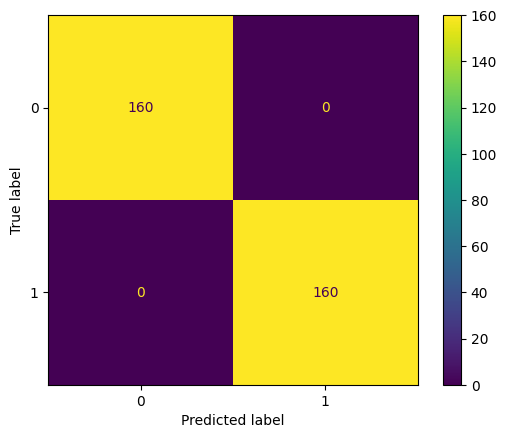

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred)).plot()

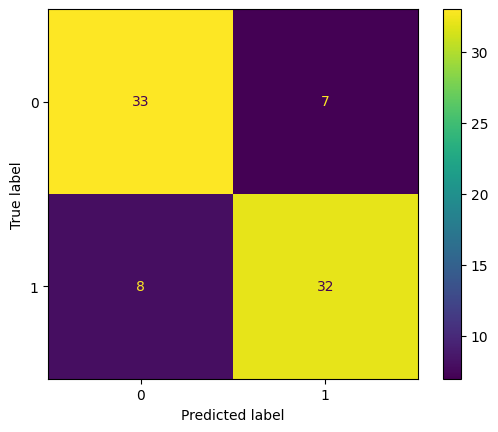

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred)).plot()

Now let's have a look at the text of test set that the classifier got wrong

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
X_test[y_test != y_test_pred][['text', 'label']]

text  \
180  Well, as Goethe once said, there really isn't any point in trying to pass a negative judgement that aspires to be objective on "something that has had a great effect". "La Maman et La Putain" has surely passed into history as an influence on much of what's been done in France and elsewhere in the past thirty years and no one interested in the history of film, certainly, should be dissuaded from watching it. To express a purely subjective judgement, however, I feel compelled to disagree with almost every other review posted here and say to people: "Don't watch it; it's a waste of hours of your time that will just leave you feeling rather sick and angry." And by that I don't mean "sick and angry" about "the human condition" or anything so general and profound as that, because that is exactly the line that most critics have adopted in their fulsome praise of the film - "an ordeal to watch in its ruthless dissection of our emotional cowardice and cruelty" and so on - and, if it really managed to put across a universally or even broadly relevant message of this sort, then the director would have good reason to be satisfied with himself, however pessimistic his conclusions may be. My beef with the film is rather that I don't see this hours-long record of empty vanity and petty treachery as being justified or excused by any GENERALLY relevant message at all. All three main characters are deeply morally unattractive individuals: Alexandre to the greatest degree, of course, because we see by far the most of him and because he seldom shuts up for more than thirty seconds; Marie perhaps to the least degree, because we see the least of her. Alexandre's affected and pretentious monologues have a kind of amusement value, of course, but the amusement wears thin as one comes more and more clearly to realize that Jean-Pierre Léaud is most likely not even acting and that, with absurd remarks like "un homme beau comme un film de Nicholas Ray", he really was just reproducing word-for-word opinions that were accepted as authentic and profound by the milieu in which he, along with the director Eustache, had been living for about ten years by the time of the making of the film. I suppose if the tone of relentless superficiality and triviality had been sustained throughout 100% of the film, it might have worked as a long sardonic comedy about a particularly shallow, worthless and despicable post-'68 milieu. What made, however, this viewer at least extremely angry with the director was his granting of at least one lengthy scene each to Alexandre and Veronika in which we are clearly expected to empathize with and feel for them as if they shared a moral universe with us. If a man can get away with living in the flat of and professing to love one woman, sleeping (mostly in this very flat) with another, and running around Paris proposing marriage to yet a third, well, I suppose I can wish him the best of luck in the dog-eat-dog world he's chosen to create for himself. What I can't, however, in all conscience do is listen even for a moment to maudlin monologues from him in which he speaks about his "anxiety" and his "despair". The same goes double for the even more despicable Veronika, whom we are shown barging drunk into the apartment and even the bed shared by Marie and Alexandre and behaving there with an infantile inconsistency tantamount to the most savage and heartless cruelty. As I say, if "La Maman et La Putain" is intended to be nothing more nor other than a portrait of Alexandre, Veronika and Marie, three individuals whom any even halfway decent person would never admit into their company let alone their home, then I suppose there is a kind of legitimacy in praising the director for being "unflinching" (though why one should even feel like "flinching" once one had consciously opted to create such thoroughly repellent characters to filmically observe I can't imagine). The problem, however, is that the director is clearly convinced - a

In this exercise, a hybrid approach was applied, combining the strengths of both Transformer-based models and traditional machine learning. Specifically, a pre-trained SentenceTransformer model (based on BERT) was used to generate high-dimensional embeddings as features for the input text data. These embeddings captured the contextual meaning of the reviews, transforming the text into numerical representations. Subsequently, a Histogram Gradient Boosting Classifier, a supervised learning algorithm, was employed to utilize these features and classify the reviews as positive or negative. This approach leveraged the powerful feature extraction capabilities of the Transformer model while taking advantage of the efficiency and interpretability of a traditional machine learning classifier. This workflow demonstrates the flexibility of integrating modern NLP techniques with classical supervised learning frameworks.

